In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Last Date: {last_date[0]}')
      
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

Last Date: 2017-08-23


Text(0, 0.5, 'Precipatation Measurement')

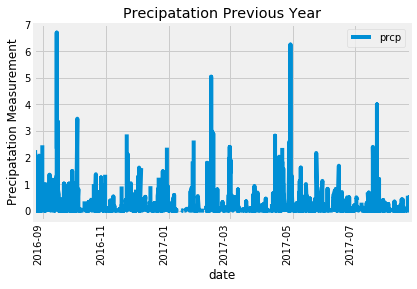

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
precip_df['date'] = pd.to_datetime(precip_df['date'])



# Sort the dataframe by date
precip_df = precip_df.set_index(['date']).sort_index()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(rot=90)
ax.set_title('Precipatation Previous Year')
ax.set_ylabel('Precipatation Measurement')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.id)).all()
stations

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_rows = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
stations_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281 = session.query(Measurement.date,Measurement.tobs)\
                        .filter(Measurement.station == 'USC00519281')\
                        .filter(Measurement.date > '2016-08-23').all()
station_USC00519281[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

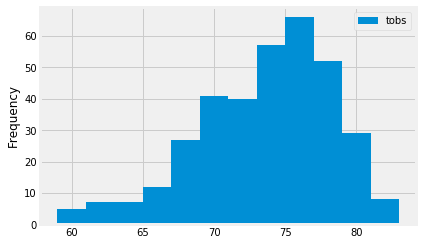

In [19]:
station_USC00519281_df = pd.DataFrame(station_USC00519281)
station_USC00519281_df.plot(kind='hist',bins=12)

## Bonus Challenge Assignment

### Temperature Analysis I

In [20]:
# June and December Temps
june = session.query(Measurement.date, Measurement.tobs)\
            .filter(func.strftime("%m",Measurement.date) == '06').all()
dec = session.query(Measurement.date, Measurement.tobs)\
            .filter(func.strftime("%m",Measurement.date) == '12').all()

# convert to pandas
june_df = pd.DataFrame(june, columns=['Date', 'Temp'])
june_df["Month"] = "June"
dec_df = pd.DataFrame(dec, columns=['Date', 'Temp'])
dec_df["Month"] = "December"

#join
temp_df = pd.concat([june_df,dec_df], ignore_index=True)

# calculate the average for both June and December
avg_temp = temp_df.groupby("Month").mean()
avg_temp

,Temp
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

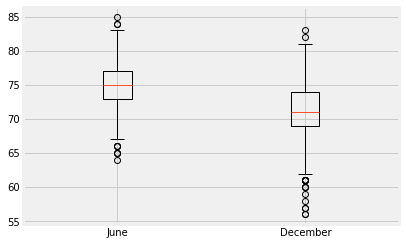

In [21]:
box_data = [june_df["Temp"],dec_df["Temp"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temp"], dec_df["Temp"])

P value is less than .05 so we can conclude the difference in means is statistically significant.  There is a meaningful difference in temperature between june and december

### Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-09-01'
trip_end = '2016-09-08'

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

def get_last_year_dates(start_date, end_date):
    
    last_year_start_date = (dt.datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_end_date = (dt.datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_start_date, last_year_end_date

last_start_date, last_end_date = get_last_year_dates(trip_start, trip_end)

tmin, tavg, tmax = calc_temps(trip_start,trip_end)[0]
print(tmin, tavg, tmax)

73.0 78.04166666666667 84.0


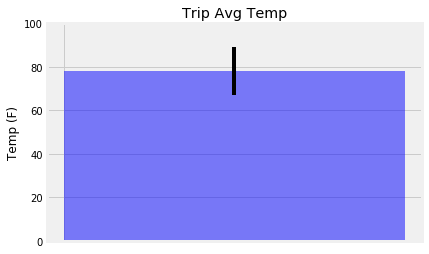

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure();
plt.bar(x="",height=tavg,yerr=tmax-tmin,color='b',alpha=.5,align='edge');
plt.ylim(0,100);
plt.ylabel("Temp (F)");
plt.title("Trip Avg Temp");

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query_columns = [Station.station, Station.name, func.sum(Measurement.tobs), \
                 Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*query_columns).group_by(Measurement.station)\
                        .outerjoin(Station, Measurement.station==Station.station)\
                        .filter(Measurement.date >= last_start_date).filter(Measurement.date <= last_end_date)\
                        .order_by(func.sum(Measurement.tobs).desc()).all()
last_year_data
trip_df = pd.DataFrame(last_year_data,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)
trip_df

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",632.0,21.27160,-157.81680,3.0
1,USC00519281,"WAIHEE 837.5, HI US",627.0,21.45167,-157.84889,32.9
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",612.0,21.33310,-157.80250,152.4
3,USC00513117,"KANEOHE 838.1, HI US",552.0,21.42340,-157.80150,14.6
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",479.0,21.52130,-157.83740,7.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",470.0,21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",398.0,21.39340,-157.97510,11.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",225.0,21.31520,-157.99920,0.9


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

rain_start_date = dt.datetime.strptime(trip_start,'%Y-%m-%d')
rain_end_date = dt.datetime.strptime(trip_end,'%Y-%m-%d') 
delta = rain_end_date - rain_start_date
normals = []

for i in range(delta.days + 1):
    day = rain_start_date + dt.timedelta(days=i)
    month_day = dt.datetime.strftime(day,'%m-%d')
    normals.append(month_day)
    
normal_list = []
for day in normals:
    normal_list.append(daily_normals(day)[0])
    
normal_list


[(69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0),
 (64.0, 75.18, 82.0),
 (66.0, 76.22222222222223, 83.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
09-01,69.0,77.000000,82.0
09-02,67.0,76.666667,83.0
09-03,69.0,76.137255,83.0
09-04,68.0,76.270833,84.0
09-05,66.0,75.914894,84.0
09-06,66.0,74.911111,81.0
09-07,64.0,75.180000,82.0
09-08,66.0,76.222222,83.0


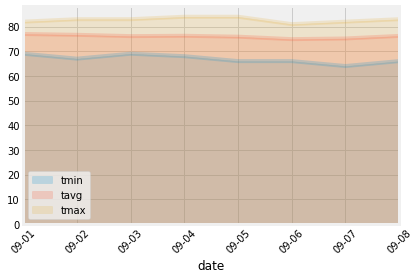

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False,rot=45,alpha=.2);
plt.xlabel("date");